In [ ]:
!pip install awswrangler
import awswrangler as wr
import boto3
import pandas as pd
import numpy as np
import re
from sagemaker import get_execution_role
import matplotlib.pyplot as plt
from tqdm import tqdm 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix, auc

role = get_execution_role()
s3 = boto3.resource('s3')

In [ ]:
pip install --upgrade pip

In [ ]:
pip install scikit-learn==0.24.2

In [5]:
import pickle 

Load trained model and Cataluinia dataset


In [6]:
with open("./crr_model.pkl", 'rb') as f:
       model = pickle.load(f)
        
        

In [18]:
model.n_features_in_

18

In [23]:
data= pd.read_csv('catalunia_dataset_cleaned.csv')
data.columns

Index(['a_patientid', 'RRT', 'crrt_time', 'aki_stage', 'crrt_24_134_h',
       'spo2_min', 'spo2_max', 'albumine_min', 'scr_min', 'haematocrit_min',
       'potassium_min', 'bun_min', 'ph_min', 'albumine_max', 'scr_max',
       'haematocrit_max', 'potassium_max', 'bun_max', 'ph_max',
       'chronic kidney disease', 'diabetes', 'hypertension', 'heart failure',
       'exclude_per_crrt', 'exclude_per_stage'],
      dtype='object')

SELECT RIGHT COLUMNS AND MAKE PREDICTIONS

In [24]:
# Select variables for the model.
columns = [
    'spo2_min', 
    'spo2_max', 
    'albumine_min', 
    'scr_min', 
    'haematocrit_min',
    'potassium_min', 
    'bun_min',
    'ph_min', 
    'albumine_max', 
    'scr_max',
    'haematocrit_max', 
    'potassium_max', 
    'bun_max', 
    'ph_max',
    'chronic kidney disease',
    'diabetes', 
    'hypertension', 
    'heart failure',
]

categorical = [
    'chronic kidney disease',
    'diabetes', 
    'hypertension', 
    'heart failure',
]

numerical = [x for x in columns if x not in categorical]

In [80]:
sc = StandardScaler()

In [81]:
X_test = data[columns]
X_test

,spo2_min,spo2_max,albumine_min,scr_min,haematocrit_min,potassium_min,bun_min,ph_min,albumine_max,scr_max,haematocrit_max,potassium_max,bun_max,ph_max,chronic kidney disease,diabetes,hypertension,heart failure
0,90.0,100.0,2.68,1.07,29.0,2.50,21.777,7.46,2.68,1.07,33.0,3.20,21.777,7.49,0.0,0.0,0.0,0.0
1,78.0,100.0,2.39,4.15,23.7,3.20,44.625,7.35,2.39,4.15,27.0,4.40,44.625,7.51,0.0,0.0,0.0,0.0
2,88.0,100.0,2.53,1.16,27.8,3.92,23.205,7.46,2.53,1.16,29.0,3.92,23.205,7.46,0.0,1.0,1.0,0.0
3,73.0,100.0,2.13,0.45,25.0,3.10,11.067,7.50,2.13,0.45,29.5,3.50,11.067,7.57,0.0,0.0,0.0,0.0
4,92.0,100.0,2.89,0.85,36.2,4.49,16.422,7.36,2.89,0.85,36.5,4.49,16.422,7.36,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2580,91.0,100.0,2.50,1.06,31.9,3.48,13.566,7.37,2.90,1.18,34.7,4.49,13.923,7.39,0.0,0.0,0.0,0.0
2581,84.0,100.0,2.90,1.53,34.2,3.42,7.140,7.23,2.90,2.58,44.2,4.81,13.923,7.31,0.0,0.0,0.0,0.0
2582,88.0,100.0,3.40,1.04,29.6,3.92,19.635,7.37,3.40,1.21,30.6,4.62,20.349,7.37,0.0,0.0,1.0,0.0
2583,91.0,100.0,2.70,0.81,23.7,3.74,14.280,7.42,2.70,0.84,25.2,4.04,16.065,7.42,0.0,0.0,0.0,0.0


In [82]:
y_test = data['crrt_24_134_h'].ravel()
y_test

array([0, 0, 0, ..., 0, 0, 0])

In [83]:
X_num_test = sc.fit_transform(X_test[numerical])
X_cat_test = X_test[categorical]
    
X_test_proc = np.hstack((X_num_test, X_cat_test))
X_test_proc.shape

(2585, 18)

In [84]:
yHat = model.predict_proba(X_test_proc)[:,1]
yHat

array([0.3083389 , 0.92874958, 0.37772958, ..., 0.40643033, 0.27083247,
       0.27090543])

INCIDENCE

In [85]:
100*(y_test.sum()/X_test_proc.shape[0])

4.332688588007737

n° patients in class 1

In [86]:
y_test.sum()

112

n° patients (Total)

In [87]:
X_test_proc.shape[0]

2585

COMPUTE ROC CURVE

In [88]:
fpr, tpr, _ = roc_curve(y_test, yHat)
rocauc = auc(fpr, tpr)

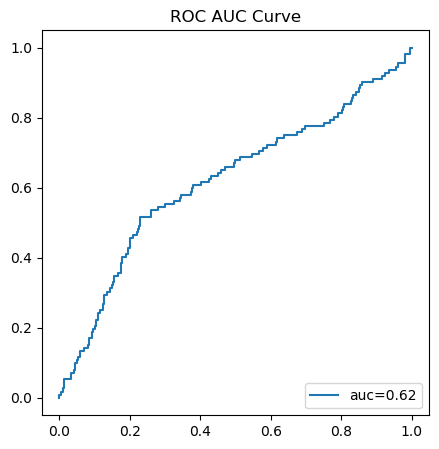

In [89]:
plt.figure(figsize=(5,5))
plt.title('ROC AUC Curve')
plt.plot(fpr, tpr, label=f'auc={round(rocauc, 3)}')
plt.legend(loc=4)
plt.show()

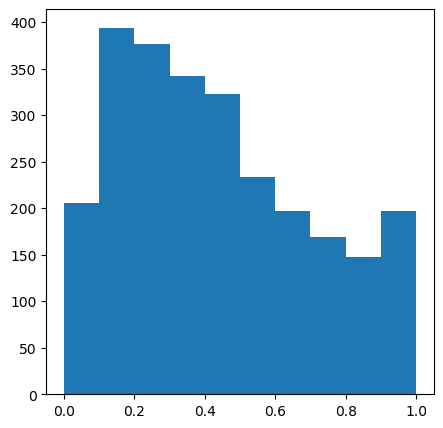

In [90]:
plt.figure(figsize=(5,5))
plt.hist(yHat)
plt.show()

In [91]:
ypred = (yHat>= 0.5)

PLOT CLASSIFICATION REPORT

In [65]:
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           0       0.97      0.64      0.77      2473
           1       0.07      0.58      0.12       112

    accuracy                           0.64      2585
   macro avg       0.52      0.61      0.45      2585
weighted avg       0.93      0.64      0.75      2585



Plot ROC curves for AKI stratified by stage.


In [92]:
data['aki_stage'].unique()

array([1., 2., 3.])

In [93]:
data['prediction'] = yHat

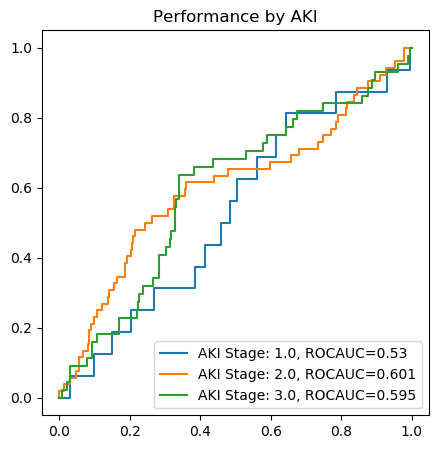

In [94]:
# Plot ROC curves for AKI stratified by stage.
plt.figure(figsize=(5,5))
for aki in data['aki_stage'].unique():
    tmp = data[data['aki_stage'] == aki]
    ytest = tmp['crrt_24_134_h'].ravel()
    ypred = tmp['prediction'].values
    fpr, tpr, _ = roc_curve(ytest, ypred)
    rocauc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'AKI Stage: {aki}, ROCAUC={round(rocauc, 3)}')
plt.legend(loc=4)
plt.title("Performance by AKI")
plt.show()